# Preprocessing Cheat Sheet
```PSMCV-2.2024-2025.1```

Authors: 
- Robbert van der Mijn, w.r.van.der.mijn@rug.nl, 2022
- Mark Span, m.m.span@rug.nl, 2024

See also the tutorial at: https://pydatamatrix.eu/1.0/eyelinkparser/

and definitely:

Mathôt S, Vilotijević A. Methods in cognitive pupillometry: Design, preprocessing, and statistical analysis. Behav Res Methods. 2023 Sep;55(6):3055-3077. doi: 10.3758/s13428-022-01957-7. Epub 2022 Aug 26. PMID: 36028608; PMCID: PMC10556184.

Additional References
Kahneman, D., & Beatty, J. (1966). Pupil diameter and load on memory. Science, 154(3756), 1583–1585. https://doi.org/10.1126/science.154.3756.1583
Mathôt, S., (2018). Pupillometry: Psychology, Physiology, and Function. Journal of Cognition. 1(1), p.16. https://doi.org/10.5334/joc.18

# Experiment Overview

We are conducting an experiment to analyze how subjects decide whether the provided answer to arithmetic problems is correct or incorrect. The experiment includes both simple and moderately challenging arithmetic problems. The hypothesis is that solving more difficult problems will elicit different pupil responses compared to simpler problems.

### Subjects and Task
Four subjects participated in the task. Each subject was presented with an arithmetic problem displayed on the screen, followed by a suggested answer. The subjects then responded by pressing the 'f' key if they believed the answer was incorrect, or the 'j' key if they believed the answer was correct. The objective is to measure the accuracy and response time in relation to the difficulty of the problems.

### Eyetracker Integration
To monitor the different stages of each trial, we sent specific messages to the eyetracker, which are embedded within the eyetracker data. These messages help in segmenting the data according to the phases of the trial. The sequence of phases and corresponding messages used in OpenSesame is as follows:

1. Start Trial: Initiated with the message "start_trial".
1. Baseline Phase: Marked with the message "baseline".
1. Problem Presentation: Indicated by the message "problem".
1. Fixation Phase: Marked by the message "fixation".
1. Response Phase: Denoted by the message "response".
1. Feedback Phase: Signified by the message "feedback".
1. End Trial: Concluded with the message "stop_trial".

### Data Collection
For each trial, the following data points are recorded:

Difficulty: The level of difficulty of the arithmetic problem (simple or more difficult).
Response: The key pressed by the subject ('f' or 'j').
Correctness: Whether the subject's response was correct or incorrect.

This detailed data collection allows us to analyze the relationship between problem difficulty, pupil response, and the accuracy of the subject's answers.

## Modules and Packages

This section outlines the necessary modules and packages required for the analysis of the pupil data. Ensure that all these packages are installed in your environment.

- **eyelinkparser**: A package for parsing EyeLink data files.
- **datamatrix**: A library for working with data matrices, providing functionality for data manipulation and analysis.
- **numpy**: A fundamental package for numerical computations in Python.
- **scipy**: A library used for scientific and technical computing.
- **matplotlib**: A library for plotting data


## Data Loading

This section covers the steps required to load the data into the notebook.

The data will be represented in python using DataMatrices. These are structures tailored to be able to contain the information that is associated with trial-based eyetracking data.

To imagine what your data should look like, we first take a step back: 

For each phase, timeseries will be created with information about fixations:

- fixxlist_[phase name] is a series of X coordinates
- fixylist_[phase name] is a series of Y coordinates
- fixstlist_[phase name] is a series of fixation start times
- fixetlist_[phase name] is a series of fixation end times

and info on the blinks:

- blinkstlist_[phase name] is a series of blink start times
- blinketlist_[phase name] is a series of blink end times

Additionally, four columns will be created with information about individual gaze samples:

- xtrace_[phase name] is a series of X coordinates
- ytrace_[phase name] is a series of Y coordinates
- ttrace_[phase name] is a series of time stamps
- ptrace_[phase name] is a series of pupil sizes

**We** are only interested in the last trace. This is the size of the pupil, in "Arbitrary Units".


In [1]:
# Datamatrix is also from Sebastiaan. You need a conveinient method to manage all your data.
# The code below is needed to use the libraries that do the hard work for us.

from datamatrix import (
    plot,
    operations as ops,
    series as srs,
    functional as fnc,
    SeriesColumn,
)

from eyelinkparser import parse, defaulttraceprocessor
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.font_manager


## Declaring a function

The eyelinkparser needs info from you on what your trials look like (the *phases*. Therefore you need to write a function that reads in your trials and defines its structure in there. Like this:

In [2]:
def my_preprocessor():
    
    dm = parse(
        traceprocessor = defaulttraceprocessor(
          blinkreconstruct = True,
          mode= 'advanced',
          downsample = None
        )
    )
    
    # define the max depth manually: baseline, problem, fixation, response and feedback
    MAX_DEPTH = 1500 + 800 + 2500 + 2000 

    # get the current max depth, we'll be cutting it off later
    max_depth = dm.ptrace_baseline.depth + dm.ptrace_problem.depth + dm.ptrace_fixation.depth + dm.ptrace_response.depth + dm.ptrace_feedback.depth

    # Create new series column that will hold our new pupil trace
    dm.pupil = SeriesColumn(depth = max_depth)

    # For each trial, trim pupil traces based on the nan values in the time trace (there are more elegant solutions I'm sure)
    for i, row in enumerate(dm):
        ptrace_baseline = row.ptrace_baseline[~np.isnan(row.ttrace_baseline)]
        ptrace_problem  = row.ptrace_problem[~np.isnan(row.ttrace_problem)]
        ptrace_fixation = row.ptrace_fixation[~np.isnan(row.ttrace_fixation)]
        ptrace_response = row.ptrace_response[~np.isnan(row.ttrace_response)]
        ptrace_feedback = row.ptrace_feedback[~np.isnan(row.ttrace_feedback)]
        
        # Concatenate and pad so they're all the same depth
        pupil = np.concatenate((ptrace_baseline, ptrace_problem, ptrace_fixation, ptrace_response, ptrace_feedback))
        pupil = np.pad(pupil, (0, max_depth - len(pupil)), "constant", constant_values = np.nan)
        
        # Write this trial to the original dm
        dm.pupil[i] = pupil
        
    # Trim the original dm to our manual depth (the feedback phase of some of the really long trials will be cut off)
    dm.pupil.depth = MAX_DEPTH
    # and return only the data we want to analyse. 
    dm = dm[("subject_nr", "pupil", "count_trial_sequence", "correct", "difficulty", "practice")]
    
    return dm


Notice that running the above code does nothing yet. It defines a function that will read your data, and creates a timeseries for each trial containing the pupilsize data. Also, note that for your own experiment, you will have to supply the phases that define your trial, and the total time that a trial can take in this part of your script!

In [3]:
# Actually reading the data 

dm = my_preprocessor()
dm

............................................................................................................................................................................................................................

correct,count_trial_sequence,difficulty,practice,pupil(6800),subject_nr
1,0,easy,yes,[1523. 1522. ... 1676. 1677.],1
1,1,hard,yes,[1694. 1690. ... 1745. 1745.],1
1,2,easy,yes,[1455. 1459. ... 1458. 1461.],1
1,3,easy,yes,[1236. 1235. ... nan nan],1
1,4,hard,no,[1273. 1272. ... 1487. 1489.],1
1,5,easy,no,[1412. 1412. ... 1323. 1324.],1
1,6,hard,no,[1213. 1214. ... 1586. 1587.],1
1,7,easy,no,[1323. 1324. ... 1304. 1303.],1
1,8,easy,no,[1266. 1265. ... 1331. 1331.],1
1,9,hard,no,[1312. 1313. ... 1406. 1406.],1


Again: notice that ```dm``` is a *datamatrix*. It contains all the data we need to analyse the pupil responses to each of the trial categories.

Now select the non-practice trials:

In [4]:
dm = (dm.practice == 'no')
dm

correct,count_trial_sequence,difficulty,practice,pupil(6800),subject_nr
1,4,hard,no,[1273. 1272. ... 1487. 1489.],1
1,5,easy,no,[1412. 1412. ... 1323. 1324.],1
1,6,hard,no,[1213. 1214. ... 1586. 1587.],1
1,7,easy,no,[1323. 1324. ... 1304. 1303.],1
1,8,easy,no,[1266. 1265. ... 1331. 1331.],1
1,9,hard,no,[1312. 1313. ... 1406. 1406.],1
1,10,easy,no,[1214. 1210. ... nan nan],1
1,11,easy,no,[1232. 1232. ... nan nan],1
1,12,easy,no,[1185. 1188. ... 1398. 1397.],1
1,13,hard,no,[1181. 1182. ... nan nan],1


Of course, you could also select only the correct trials here. We will not do so, so we can show you how to plot and test multiple variable designs.

# Blinkreconstruction

(One of) the most interesting parts of the eyelinkparser is this:

```
dm = parse(
        traceprocessor = defaulttraceprocessor(
          blinkreconstruct = True,
          mode= 'advanced',
          downsample = None
        )
    )
```

In our analysis, blink reconstruction is enabled with the mode set to 'advanced'. During blinks, data on pupil size is unavailable. To address this, the parser imputes the missing data based on established methods [reference needed]. The procedure involves two main steps:

1. Correction of Blink-Affected Data: The time series data immediately before and after a blink, which may be influenced by the blink (due to the closing and reopening of the eyes), are adjusted to mitigate any artifacts caused by the blink. This ensures that the data reflects the true pupil size changes rather than the mechanical effects of blinking.

1. Interpolation During Blinks: The time series data during the blink itself, where data is completely missing, is interpolated. This interpolation fills in the missing data points in a way that maintains the continuity and trend of the pupil size data, providing a seamless transition across the blink period.

This advanced blink reconstruction technique ensures that the pupil size data is as accurate and reliable as possible, minimizing the impact of blinks on the overall analysis.



## Data Cleaning

In this example, the data cleaning is automated. This is not always possible, and therefore this placeholder title is inserted. If needed: Clean your data here.

## Baseline Correction

As we are interested in the *reaction* of the pupil, we start with a baseline correction. The period just before our period of interest is defined as a baseline, and set to 0. The change from this baseline now is the variable we are testing and plotting.

As a baseline, we could use the last ten samples of the basline trace. As the basline is 1500 smples long, we can define this as follows:


In [5]:
dm.pupil = srs.baseline(
    series=dm.pupil,
    baseline=dm.pupil,
    bl_start=1490,
    bl_end=1500
)

/srv/conda/envs/notebook/lib/python3.12/site-packages/datamatrix/multidimensional.py:243: RuntimeWarning: All-NaN slice encountered
  a = operation(col, axis=np.arange(1, len(col.shape)))


## Data Visualization

This section provides methods for visualizing the data to gain insights.

### Saving plots as pngs

We use MatPlotLib for plotting here. There is sometimes an issue with the fonts matplotlib defaults to. Hopefully this is a fix for that. If you have many warnings about fonts, please let me know...

In [6]:
import matplotlib as mpl
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "DejaVu Sans"

# Individual Traces

Plot all different traces into one single plot. This will reveal problems in your data.

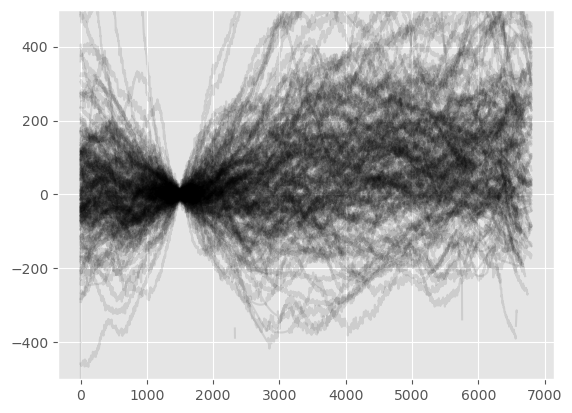

In [7]:
for row in dm:    
    plt.plot(row.pupil, alpha = .1, color = "black")
plt.ylim(-500, 500)
plt.savefig('all_trials.png', bbox_inches='tight')

Note the "bow-tie" shape of the plot. Why is that?

# Grand averages

Plot the overall average pupil size during the trials:

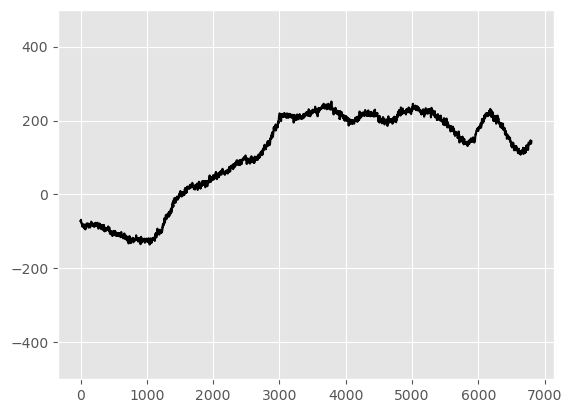

In [8]:
plt.plot(dm.pupil[0], color = "black")
plt.ylim(-500, 500)
plt.savefig('single_trial.png', bbox_inches='tight')

# Testing the effects


reference: https://github.com/smathot/time_series_test


# Plotting the experimental effects:

The *time_series_test* package (also) has easy plotting functions.

/srv/conda/envs/notebook/lib/python3.12/site-packages/datamatrix/_datamatrix/_multidimensionalcolumn.py:204: RuntimeWarning: Mean of empty slice
  return nanmean(self._seq, axis=0)
/srv/conda/envs/notebook/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


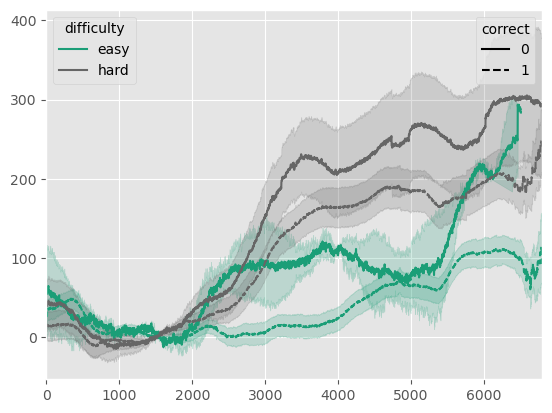

In [10]:
import time_series_test as tst
from matplotlib import pyplot as plt

tst.plot(dm, dv='pupil', hue_factor='difficulty', linestyle_factor='correct')
plt.savefig('signal-plot-1.png')

The model below uses mean pupil size during the 2500 - 3000 sample range as dependent measure, set size and color type as fixed effects, and a random by-subject intercept. In the more familiar notation of the R package lme4, this corresponds to ```mean_pupil ~ difficulty + correct + (1 | subject_nr)```. (To use more complex random-effects structures, you can use the re_formula argument to mixedlm().)

In [11]:
from statsmodels.formula.api import mixedlm
from datamatrix import series as srs, NAN

dm.mean_pupil = srs.reduce(dm.pupil[:, 2500:3000])
dm_valid_data = dm.mean_pupil != NAN
model = mixedlm(formula='mean_pupil ~ difficulty + correct',
                data=dm_valid_data, groups='subject_nr').fit()
print(model.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    mean_pupil
No. Observations:     197        Method:                REML      
No. Groups:           5          Scale:                 18577.0767
Min. group size:      38         Log-Likelihood:        -1238.4487
Max. group size:      40         Converged:             No        
Mean group size:      39.4                                        
------------------------------------------------------------------
                    Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------------
Intercept            60.950   42.237  1.443 0.149  -21.834 143.734
difficulty[T.hard]   53.039   20.219  2.623 0.009   13.412  92.667
correct             -57.413   33.697 -1.704 0.088 -123.458   8.631
subject_nr Var     2538.645   13.755                              



/srv/conda/envs/notebook/lib/python3.12/site-packages/datamatrix/multidimensional.py:246: RuntimeWarning: Mean of empty slice
  reduced_col[i] = operation(val)
/srv/conda/envs/notebook/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/envs/notebook/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/srv/conda/envs/notebook/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/srv/